In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import tensorflow as tf

In [2]:
dataset = pd.read_csv("labeled_data.csv")
dataset["labels"] = dataset["class"].map({
    0: "Hate Speech",
    1: "Offensive Language",
    2: "Neither Hate Nor Offensive"
})
data = dataset[["tweet","class"]]
data.shape

(24783, 2)

In [3]:
set_stopwords = set(stopwords.words("English"))

In [4]:
stemmer = nltk.SnowballStemmer(language = "english")

In [5]:
# DATA CLEANING
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub("https?://\S+|www.\S+",'',tweet)
    tweet = re.sub('\[.?\]','',tweet)
    tweet = re.sub("\[%s\]"%re.escape(string.punctuation),'',tweet)
    tweet = re.sub('\n','',tweet)
    tweet = re.sub('\w\d\w','',tweet)
    tweet = [word for word in tweet.split(' ') if word not in set_stopwords]
    tweet = " ".join(tweet)
    tweet = [stemmer.stem(word) for word in tweet.split(' ')]
    tweet = " ".join(tweet)
    return tweet

In [6]:
data.loc[:,"tweet"] = data.loc[:,"tweet"].apply(clean_tweet) 

In [7]:
X = np.array(data["tweet"])
Y = np.array(data["class"])
Y

array([2, 1, 1, ..., 1, 1, 2], dtype=int64)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
cv = CountVectorizer()
X = cv.fit_transform(X)

In [10]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.25, random_state = 55)

In [12]:
from tensorflow.keras.utils import to_categorical

# Convert class labels to one-hot encoded format
Y_train = to_categorical(Y_train, num_classes=3)
Y_test = to_categorical(Y_test, num_classes=3)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [15]:
X_train
type(X_train)

scipy.sparse._csr.csr_matrix

In [16]:
model = Sequential([
    Dense(units = 100, activation = "relu"),
    Dense(units = 50, activation = "relu"),
    Dense(units = 10, activation = "relu"),
    Dense(units = 3, activation = 'softmax')
])

In [17]:
model

In [18]:
from tensorflow.keras.losses import categorical_crossentropy

In [19]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [20]:
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x0000017CCACB3790>>

In [21]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)
X_train = convert_sparse_matrix_to_sparse_tensor(X_train)


In [22]:
X_train = tf.sparse.reorder(X_train)
type(X_train)

tensorflow.python.framework.sparse_tensor.SparseTensor

In [23]:
model.fit(X_train,Y_train,epochs = 25, batch_size = 100)

Epoch 1/25
186/186 [==============================] - 11s 48ms/step - loss: 0.4966 - accuracy: 0.8458
Epoch 2/25
186/186 [==============================] - 9s 47ms/step - loss: 0.2002 - accuracy: 0.9297
Epoch 3/25
186/186 [==============================] - 8s 43ms/step - loss: 0.0902 - accuracy: 0.9701
Epoch 4/25
186/186 [==============================] - 8s 44ms/step - loss: 0.0368 - accuracy: 0.9889
Epoch 5/25
186/186 [==============================] - 8s 44ms/step - loss: 0.0187 - accuracy: 0.9940
Epoch 6/25
186/186 [==============================] - 8s 42ms/step - loss: 0.0114 - accuracy: 0.9969
Epoch 7/25
186/186 [==============================] - 9s 46ms/step - loss: 0.0073 - accuracy: 0.9978
Epoch 8/25
186/186 [==============================] - 10s 52ms/step - loss: 0.0049 - accuracy: 0.9984
Epoch 9/25
186/186 [==============================] - 11s 56ms/step - loss: 0.0041 - accuracy: 0.9988
Epoch 10/25
186/186 [==============================] - 9s 48ms/step - loss: 0.0033 - acc

In [24]:
X_test = convert_sparse_matrix_to_sparse_tensor(X_test)

In [25]:
X_test = tf.sparse.reorder(X_test)

In [26]:
Y_pred = model.predict(X_test)

194/194 [==============================] - 0s 2ms/step


In [27]:
from sklearn.metrics import accuracy_score

In [28]:
Y_pred

array([[8.0463215e-06, 9.9907398e-01, 9.1791496e-04],
       [4.1175008e-06, 9.9999583e-01, 4.9176933e-08],
       [1.6077580e-07, 9.9994004e-01, 5.9834947e-05],
       ...,
       [2.7787790e-05, 9.9997187e-01, 3.5029674e-07],
       [4.4527559e-09, 9.9999940e-01, 5.7463910e-07],
       [1.4022969e-12, 1.0000000e+00, 2.7620293e-09]], dtype=float32)

In [29]:
Y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [30]:
length = len(Y_pred)
output = np.zeros(length)
test = np.zeros(length)
for i in range(length):
    output[i] = np.argmax(Y_pred[i])
    test[i] = np.argmax(Y_test[i])

In [31]:
output

array([1., 1., 1., ..., 1., 1., 1.])

In [32]:
test

array([1., 1., 1., ..., 1., 1., 1.])

In [33]:
print(accuracy_score(output,test))

0.8847643641058748


Text(0.5, 3.722222222222216, 'Truth')

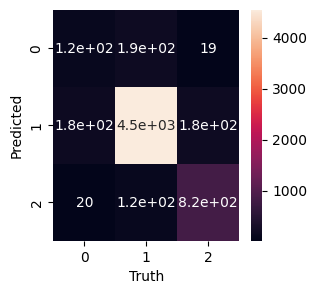

In [34]:
cm  = confusion_matrix(output,test)
plt.figure(figsize = (3,3))
sn.heatmap(cm,annot = True)
plt.ylabel("Predicted")
plt.xlabel("Truth")

In [35]:
cm

array([[ 119,  191,   19],
       [ 175, 4546,  185],
       [  20,  124,  817]], dtype=int64)

In [36]:
import pickle

In [37]:
with open("NN_model","wb") as f:
    pickle.dump(model,f)

In [38]:
with open("NN_vocabulary","wb") as f:
    pickle.dump(cv.vocabulary_,f)